In [33]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


CEPH1463 Setup
==============

We first download the ceph1463 VCF and ped into our data-directory and then run peddy.

We can see the time taken for each check.


In [34]:
DATA = "/data/" # directory where VCFs are KEPT

In [35]:
%%bash -s $DATA
DATA=$1
echo "$1"
mkdir -p plots/
python -m peddy --prefix plots/ceph1463 --plot ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.ped

/data/

ped_check
ran in 5.8 seconds
het_check
ran in 12.3 seconds
sex_check
ran in 6.2 seconds


/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/ipython-4.0.0-py2.7.egg/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
loaded and subsetted thousand-genomes genotypes in 0.8 seconds
ran randomized PCA on thousand-genomes samples at 18984 sites in 3.8 seconds
Projected thousand-genomes genotypes and sample genotypes and predicted ancestry via SVM in 0.5 seconds
sex-check: 12404 skipped / 100000 kept


HTML OUTPUT
===========

Below, we embed the HTML output that is the result of the run above.

As expected, we don't see any problems with this data from the well-studied 17-member CEPH pedigree.

In [36]:
from IPython.display import HTML
HTML(data="<iframe src='plots/ceph1463.html' width='100%' height='600px'></iframe>")

Compare to KING
===============

In order to compare to king we need to have plink (and king) installed. We show the time to run both of these on the dataset and then compare the results to those from peddy.

In [51]:
%%bash -s $DATA
DATA=$1
PATH=$DATA:$PATH

if [[ -x $(which plink2) ]]; then
    echo "OK"
else
    conda install -y -c bioconda plink2
fi
cd $DATA
if [[ -x $(which king) ]]; then
    echo "king"
else
    wget http://people.virginia.edu/~wc9c/KING/Linux-king.tar.gz
    tar xzvf Linux-king.tar.gz
fi
cd -

bash ../scripts/king-compare.sh $DATA/ceph1463.vcf.gz 

OK
king
/usr/local/src/peddy/data
ceph1463
PLINK v1.90b1g 64-bit (10 Jun 2014)        https://www.cog-genomics.org/plink2
(C) 2005-2014 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ceph1463.log.
7885 MB RAM detected; reserving 3942 MB for main workspace.
Allocated 2956 MB successfully, after larger attempt(s) failed.
--vcf: ceph1463-temporary.bed + ceph1463-temporary.bim + ceph1463-temporary.fam
written.
(394182 variants skipped.)
7695880 variants loaded from .bim file.
17 people (0 males, 0 females, 17 ambiguous) loaded from .fam.
Ambiguous sex IDs written to ceph1463.nosex .
Using 1 thread (no multithreaded calculations invoked).
Calculating allele frequencies... 0%1%2%3%4%5%6%7%8%9%10%11%12%13%14%15%16%17%18%19%20%21%22%23%24%25%26%27%28%29%30%31%32%33%34%35%36%37%38%39%40%41%42%43%44%45%46%47%48%49%50%51%52%

+ VCF=/data//ceph1463.vcf.gz
++ basename /data//ceph1463.vcf.gz .vcf.gz
+ prefix=ceph1463
+ echo ceph1463
+ /usr/bin/time plink --const-fid --allow-extra-chr --vcf /data//ceph1463.vcf.gz --make-bed --out ceph1463 --biallelic-only --geno 0.95 --vcf-half-call m
45.30user 1.49system 0:48.38elapsed 96%CPU (0avgtext+0avgdata 448180maxresident)k
3139584inputs+814960outputs (5major+91671minor)pagefaults 0swaps
+ /usr/bin/time king --ibs -b ceph1463.bed --kinship --prefix ceph1463
10.59user 1.26system 0:11.99elapsed 98%CPU (0avgtext+0avgdata 1880204maxresident)k
82880inputs+5544outputs (4major+440298minor)pagefaults 0swaps


We can see that plink took 45 seconds and KING took 10.5 seconds to run. Now, we compare to the peddy results

<IPython.core.display.Javascript object>


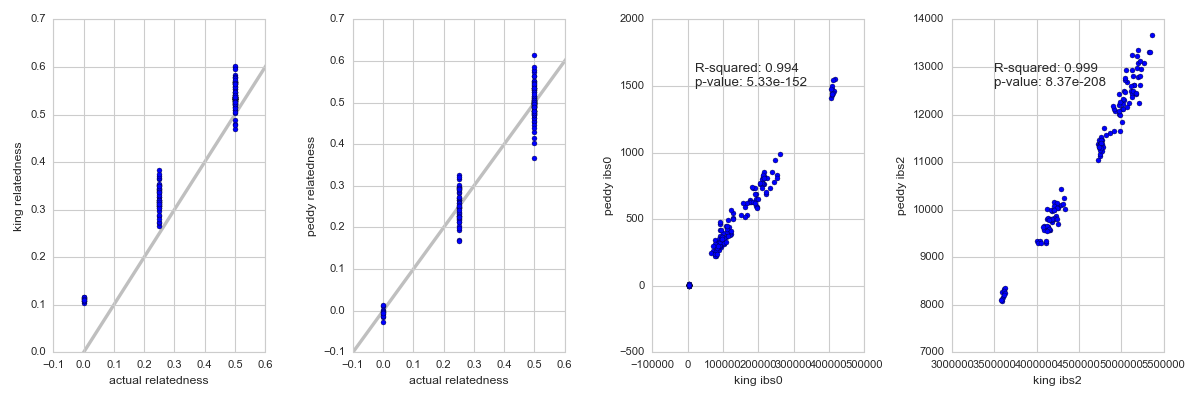

<IPython.core.display.Javascript object>


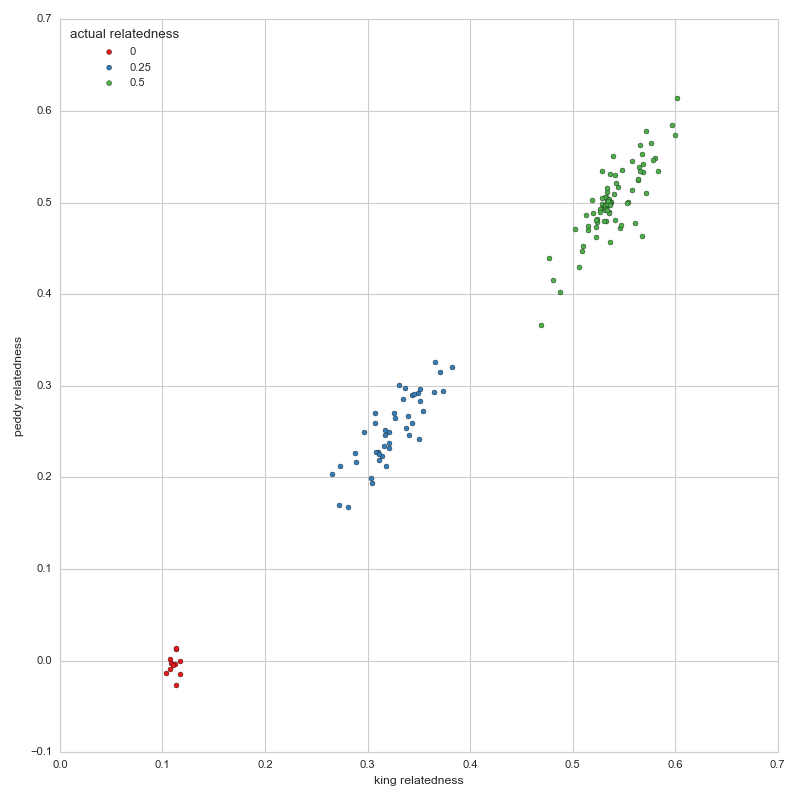

In [72]:
%matplotlib notebook
%run ../scripts/king-compare.py ceph1463.ibs $DATA/ceph1463.ped_check.csv $DATA/ceph-king-vs-peddy.eps

Convergence
===========

We sample 23,556 sites by default. Though the user can specify their own sites. We run peddy specifying the `--each` flag which will sub-sample
the sites to the number requested e.g. `--each 4` will have about 5900 sites.

We run the same command, only changing the value to each and then plot the convergence.


In [1]:
%%bash -s $DATA
DATA=$1
for e in $(seq 1 20); do
    python -m peddy --prefix plots/each-$e-ceph1463 ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.ped --each $e 2> err
done

<IPython.core.display.Javascript object>


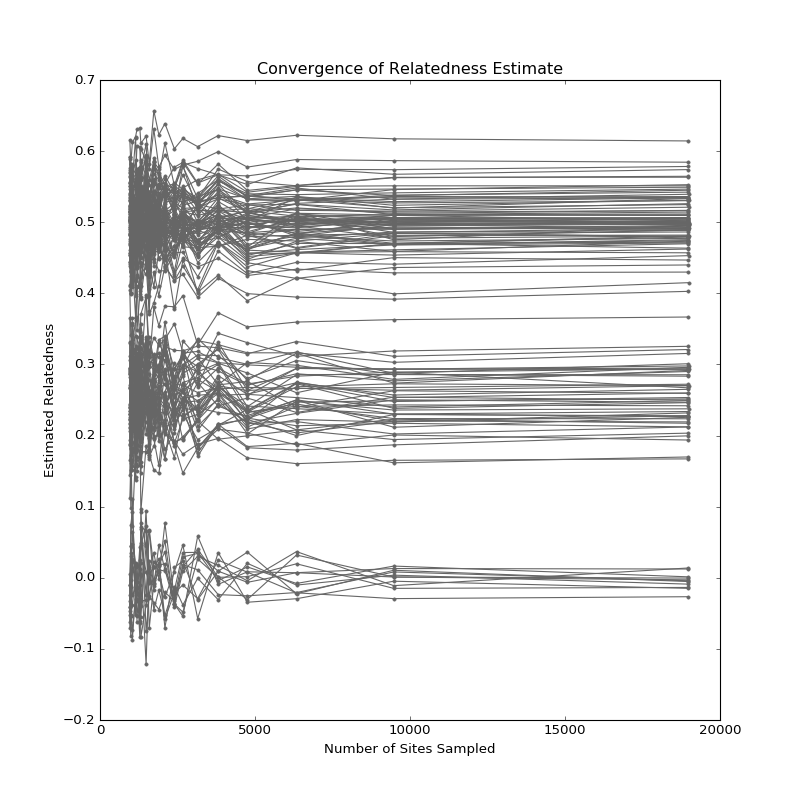

In [7]:
%matplotlib notebook

import toolshed as ts
import collections
from matplotlib import pyplot as plt

lines = collections.defaultdict(list)
for i in range(1, 21):
    f = "plots/each-%d-ceph1463.ped_check.csv" % i
    for d in ts.reader(f, sep=","):
        key = d['sample_a'], d['sample_b']
        lines[key].append((int(d['n']), float(d['rel'])))
        
        
fig, ax = plt.subplots(1, figsize=(10, 10))

color='0.9'
        
for (a, b), pairs in lines.items():
    xs, ys = zip(*pairs)
    ax.plot(xs, ys, marker='.', ls='-', color='0.4')
ax.set_xlabel('Number of Sites Sampled')
ax.set_ylabel('Estimated Relatedness')
ax.set_title('Convergence of Relatedness Estimate')
    
    

CEPH Error
==========

To demonstrate the use of `peddy`, we **introduce a pedigree error** on a smaller-subset. Note that we see some **unknown sample** warnings because we took a subset of the pedigree file and some samples that are listed as parents no longer appear in the file.

In [37]:
%%bash -s $DATA
DATA=$1
if [[ ! -e $DATA/ceph1463.bad.ped ]]; then
    wget --quiet -O $DATA/ceph1463.bad.ped https://github.com/brentp/peddy/raw/master/data/ceph1463.bad.ped
fi

python -m peddy --prefix plots/bad --plot ${DATA}/ceph1463.vcf.gz ${DATA}/ceph1463.bad.ped

    


ped_check
ran in 6.2 seconds
het_check
ran in 10.8 seconds
sex_check
ran in 5.5 seconds


unknown sample: NA12889 in family: CEPH1463
unknown sample: NA12892 in family: CEPH1463
unknown sample: NA12890 in family: CEPH1463
unknown sample: NA12891 in family: CEPH1463
/media/brentp/transcend/gemini_install/data/anaconda/lib/python2.7/site-packages/ipython-4.0.0-py2.7.egg/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
loaded and subsetted thousand-genomes genotypes in 0.9 seconds
ran randomized PCA on thousand-genomes samples at 15839 sites in 2.7 seconds
Projected thousand-genomes genotypes and sample genotypes and predicted ancestry via SVM in 0.3 seconds
sex-check: 9883 skipped / 100000 kept


In [38]:
HTML(data="<iframe src='plots/bad.html' width='100%' height='600px'></iframe>")

In [39]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [40]:
%watermark -v -m -p peddy,scipy,numpy,cyvcf2,scikit-learn,pandas,networkx,toolshed

CPython 2.7.12
IPython 4.0.0

peddy 0.2.2
scipy 0.16.0
numpy 1.10.4
cyvcf2 0.4.1
scikit-learn 0.17.1
pandas 0.18.0
networkx 1.11
toolshed 0.4.5

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 3.16.0-71-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
